<font size="6"><b>Module 9 Part 2: Using TensorFlow</b></font>


In this part of the module, we will use the [**TensorFlow**](https://www.tensorflow.org/) library introduced in the previous section to start building and applying learning algorithms. We will go over the corresponding syntax and theory associated to model building in TensorFlow and specifically look at building, executing and visualizing said models.

<font size="6">Table of Contents</font>

- 1 Model Construction
    - 1.1 Manually Processing Gradients
    - 1.2 Using `tf.autodiff`
    - 1.3 Using `tf.train.optimizers`
- 2 Model Execution
    - 2.1 Batch Gradient Descent
    - 2.2 Mini-Batch Gradient Descent
    - 2.3 Saving & Restoring Models
- 3 Visualizing models with TensorBoard
    - 3.1 TensorBoard overview & tf.logging
    - 3.2 Accessing TensorBoard
    - 3.2 Improving your  TensorBoard output

# Model Development

Compared to other machine learning libraries such as `Sci-Kit Learn`, TensorFlow involves quite a few more additional steps when building a model. However, these additional steps can be considered a tradeoff for more refined models (i.e. finer tuned parameters) and optimized performance. Before diving into the actual code, it is good to note that models in TensorFlow are generally split into two parts:

1.  **Building a Computation Graph**

    The first part involves creating the computation graph associated to the model scheme (refer to the previous section for more details on computation graphs and TensorFlow's architecture). Preparation in this stage includes configuring input variables, defining an appropriate loss function, and optimizing the model (i.e. `training_op`). Because of all the work involved, this stage is widely considered as the **construction phase**.

2.  **Executing the Model**

    This part involves iterating through the model created in the previous stage for $n$ number of epochs. After each epoch, your loss funciton may increase or decrease dependsing on the complexity of your model and whether or not you are using mini-batch training. That said, if your model is consturcted correctly and you have the right data, the loss should generally be decreasing over several epochs. You may also want to periodically store (or print) the loss values for your training and validation sets to ensure that your loss funciton is indeed decreasing. Finally, you may also wish to save the model at regular intervals, especially if you are training a model for hours (or days) on massive data sets.

To help grasp the concepts introduced in this module, we will go about implementing some of the techniques manually (i.e. batch gradient descent) and then using the built-in functionality available in TensorFlow to provide a comparison.

**The Dataset:**

We will be working with the *MNIST* dataset available in the `sklearn.datasets` package to build our first model. For context, this data is associated with handwritten digits, but this should not be relevant to complete the remainder of this module. Specifically, we will be implementing a multiclass softmax regression model. However, it is worth noting that using TensorFlow for a model this simple would generally be considered excessive; the main reason being the dataset itself is small. Recall that a benefit of TensorFlow is its ability to easily distribute computations to allow for sufficient performance when dealing with convoluted models with large amounts of data. That said, this simple classification model is used to illustrate the workflow for developing, executing and making predictions with TensorFlow.

Note that we will also normalize the input vectors (i.e. the data) before feeding it into our model. As you know from previous modules, it is very important to normalize (ie. standardize or scale) your data  prior to feeding it into a machine learning algorithm. This is particularily true for deep learning models, which we discuss in the next module.

In [1]:
# Load the data and the scalar
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# load the dataset
mnist = datasets.load_digits()

# Split into the explanatory and response variables
X_mnist = mnist["data"]
y_mnist = mnist["target"]

# Normalize the data
scaler = StandardScaler()
X_mnist = scaler.fit_transform(X_mnist)

# Add bias term as a new column in our X matrix
X_mnist = np.c_[np.ones((X_mnist.shape[0],1)), X_mnist]

# Train test split
X_train, X_val, y_train, y_val = train_test_split(X_mnist, y_mnist, test_size=0.2, shuffle=True)

# Print shape of final dataset for sanity purposes
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("y_train:", y_train.shape)
print("y_val:", y_val.shape)

X_train: (1437, 65)
X_val: (360, 65)
y_train: (1437,)
y_val: (360,)


## Manually Processing Gradients

As mentioned earlier, we will first manually derive the gradients and place the corresponding formulae into the global graph. In the code segment below, we will be running a multinomial logistic regression model (also known as **softmax regression**) using TensorFlow's built in matrix calculation functionalities. Below is a brief summary of the logic flow for our code.

**Step 1: Set the values for hyperparameters**
- We need to define some important hyperparameters including the learning rate, $m$ (i.e. the number of observations) and $n$ (i.e. the number of features).
    
**Step 2: Add placeholder nodes for input**

- Next we need to configure placeholder nodes for both the predictor and target variates (i.e. $X$ and $\vec{y}$). Note that in the `shape` argument, we explicitly used **`None`** to inform TensorFlow that we wish to leave the dimension as ambiguous. Doing so allows us to feed data into our graph with an arbitrary number of observations (i.e. we don't have to worry about adhering to size specifications). This becomes increasingly important when performing mini-bath gradient descent, or when we want to make predictions on new datasets with varying lengths. In this step, we also convert the y values to 'one hot encoding' using `tf.one_hot`
    
**Step 3: Add variable nodes for weights**

- Here we configure variables for the values we wish to train (i.e. our weight parameters) and initialize them (assign initial values) using the `glorot_normal` initializer. We will cover initialization techniques in more detail in module 11, for now all you need to know is that glorot initialization is generally a good default technique for most models. Note that our variable dimensions will be `[n, n_classes]` (i.e. the number of features & the number of classes in the data) as is standard for softmax regression. 
    
**Step 4: Calculate variables and outputs**

- Now we will calculate the *logit* values (i.e.the  logarithm of the odds of an event occuring), the softmax output, and the log loss. These will all be done using TensorFlow's available arithmetic operations.
    
**Step 5: Gardient descent calculations**

- Lastly, we will calculate the gradients and update the $W$ node (i.e. the weights vector) using `tf.assign`. Remember that a variable in TensorFlow will persist between runs so long as the session is not closed in between (the values are stored in the **session** and not the graph itself).
    
We now implement the algorithm presented above as follows:

In [2]:
import tensorflow as tf
from tensorflow import glorot_uniform_initializer
tf.reset_default_graph()

# STEP 1: Set the values for hyperparameters
m, n = X_train.shape 
# number of classes based on the data
n_classes = len(np.unique(y_train))
# learning and epsilon will be arbitrary for now
learning_rate = 0.01
# epsilon is added to loss function
epsilon = 1e-7

# STEP 2: Add placeholder nodes for inputs
X = tf.placeholder(dtype=tf.float32, shape=(None, n))
y = tf.placeholder(dtype=tf.int32, shape=(None))
# apply one hot encoding to the data
y_one_hot = tf.one_hot(y, n_classes)

# STEP 3: Add variable nodes for weights
# Initial value will be based on random normal distribution
W = tf.get_variable(name='weights', shape=(n, n_classes), initializer=glorot_uniform_initializer)

# STEP 4: Calculate softmax outputs
logits = tf.matmul(X, W)
# use tf.reshape to convert to column vector
y_proba = tf.exp(logits) / tf.reshape(tf.reduce_sum(tf.exp(logits), axis = -1), (-1, 1))
log_loss = -tf.reduce_mean(tf.reduce_sum(y_one_hot * tf.log(y_proba + epsilon), axis = -1))

# STEP 5: Gradient descent calculations
error = y_proba - y_one_hot
gradients = 1/m * tf.matmul(tf.transpose(X), error)
training_op = tf.assign(W, W - learning_rate * gradients)

# Initialize all variables
init = tf.global_variables_initializer()

ImportError: cannot import name 'glorot_uniform_initializer' from 'tensorflow' (C:\Users\bruno.gonzalez\Miniconda3\envs\tf2\lib\site-packages\tensorflow\__init__.py)

The graph constructed above is merely an implementation of the algorithm described earlier for calculating the gradients. If we were to run a few iterations of this graph, we would essentially be running our own version of **gradient descent**. Similar to what we did in the previous module, to run the graph we would have to open a session and evaluate the `training_op` variable node. Doing so will evaluate the computation graph and adjust the weight parameters accordingly.

Evaluating the graph is essentially the main goal of the **execution phase**. However, we will omit the details until later. As of now, we will ensure that the implementation is indeed correct by evaluating a session run. We would expect the loss to decrease after each iteration.

2.9201262
2.8979502
2.8759534
2.854136
2.8324976
2.8110366
2.7897544
2.7686496
2.7477214
2.72697


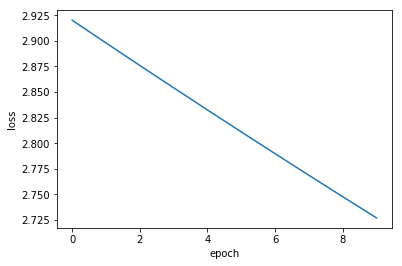

In [0]:
import matplotlib.pyplot as plt 

sess = tf.Session()
sess.run(init)

losses = []
for i in range(10):
    _, loss = sess.run([training_op, log_loss], feed_dict={X:X_train, y:y_train})
    print(loss)
    losses.append(loss)
    
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## Using `tf.autodiff`

From the most recent example, you may notice that the loss looks to be decreasing within the first five iterations. This is the behaviour that we would expect for a correctly implemented gradient descent algorithm. In fact, deriving the gradients for specific models (i.e. softmax regression, linear regression) may prove to be simple. However, this is not the case for complex models (i.e. neural networks). In the case of a multi-layer neural network, one would consider using symbolic differentiation to automatically determine the equations for the partial derivatives. But the code involved to implement such equations directly would not necessarily be the most efficient approach. 

**Example of Associated Inefficiencies:**

To illustrate this reasoning, consider some function $f(x) = \exp(\exp(\exp(x)))$ (recall that the $\exp(x)$ function is equivalent to $e^x$). The first derivative can easily be calculated as $f'(x) = \exp(\exp(\exp(x)))\cdot\exp(\exp(x))\cdot\exp(x)$ using the *Chain Rule*. If one were to implement $f(x)$ and $f'(x)$ exactly as they appeared in the equation, the approach will not be optimal since $f'(x)$ alone requires six separate calls to `exp(...)`. Furthermore, $f(x)$ would require three additional calls to the same function (which totals to nine calls among these two equations).

A more efficient proposal would be to create a function that first calculates $\exp(x)$. Then using that value, compute $\exp(\exp(x))$ and from that, compute $\exp(\exp(\exp(x)))$. These three values can then be returned as a triplet. That is, we are returning $\left(\exp(x), \exp(\exp(x)), \exp(\exp(\exp(x)))\right)$. Note that the last term in this triple is our original $f(x)$. We can also easily derive $f'(x)$ by multiplying all three terms together. Hence we only require a total of three calls to `exp(...)` in this implementation as opposed to nine when directly implementing the equations.

The direct approach also fails to capture the scenario when the function itself is not known, or if it is embedded within some code. For example, imagine computing the derivative for $f(x)$ defined below:

    def my_func(a, b):
        z = 0
        for i in range(100):
            z = a * np.cos(z + i) + z * np.sin(b - i)
        return z

This is indeed a daunting task (we don't recommend that you try!). Fortunately, the `autodiff` feature available in TensorFlow allows us to efficiently calculate the gradients of the function for us. We will update our code to accommodate for this by replacing:

    error = y_proba - y_one_hot
    gradients = 1/m * tf.matmul(tf.transpose(X),error)

with the far simpler code:

    gradients = tf.gradients(log_loss,W)[0] # extract gradients using autodiff
    
We also have the luxury of replacing the manual calculations for our probabilities and losses with the equivalent built in TensorFlow versions, which is more highly optimized (though the results should be the exact same):

    y_proba = tf.nn.softmax(logits)
    log_loss = tf.losses.log_loss(y_one_hot, y_proba)

With all the changes introduced above, we will merge everything together and update our softmax model:

In [0]:
tf.reset_default_graph()

m, n = X_train.shape 
n_classes = len(np.unique(y_train))
learning_rate = 0.01
epsilon = 1e-7 

X = tf.placeholder(dtype=tf.float32, shape=(None, n))
y = tf.placeholder(dtype=tf.int32, shape=(None))
y_one_hot = tf.one_hot(y, n_classes)

W = tf.get_variable(name='weights', shape=(n, n_classes), initializer=random_normal)
logits = tf.matmul(X, W)

# This is the updated code segment replacing all the prior implementations
# with the equivalent versions offered in TensorFlow
y_proba = tf.nn.softmax(logits)
log_loss = tf.losses.log_loss(y_one_hot, y_proba)
gradients = tf.gradients(log_loss,W)[0]
training_op = tf.assign(W, W - learning_rate * gradients)

init = tf.global_variables_initializer() 

For sanity purposes, we will rerun the algorithm again to verify that the behaviour is intact.

In [0]:
sess = tf.Session()
sess.run(init)

for i in range(5):
    _, loss = sess.run([training_op, log_loss], feed_dict={X:X_train, y:y_train})
    print(loss)

1.2968947
1.2966384
1.2963773
1.2961138
1.2958546


Evidently, computing gradients using `tf.gradients` proves to be far easier than manually deriving them.

Below is a list of the **main approaches to computing gradients automatically.** As mentioned above, Tensorflow uses reverse-mode autodiff, which works best (in terms of efficiency and accuracy) when there are a high number of inputs and only few outputs (which is usually the case for most deep learning applications). Reverse-mode autodiff can compute all of the partial derivatives of the outputs with regards to all the inputs in just **n outputs + 1 graph traversals**. 

<div style="text-align:center;margin:15px;">
<img src='./images/c4_m9_p1_graph5.png' style="float:left;width:300;height:200;">
</div>

Image Description: Overview of main differentiation techniques for neural networks

Image source: Géron, A. (2017). Chapter 9: Up and Running with TensorFlow in Hands-On Machine Learning with Scikit-Learn and TensorFlow, O’Reilly Media






We won't go into the heavy details of how these techniques work, as they require a solid understanding of calculus and are somewhat out of scope for our purposes. That said, you are encouraged to dig more into these concepts yourself! 
Aurélien Geron oﬀers an excellent introduction to the topic on his Github (https://github.com/ageron/handson-ml/blob/master/extra_autodiﬀ.ipynb).


## Using `tf.train` optimizers

On top of `autodiff`, TensorFlow also offers a number of optimiziers to be used out of the box. Such optimiziers include a Gradient Descent optimizer. To use this optimizer, we would have to replace the following code:

    gradients = tf.gradients(log_loss,W)[0] 
    training_op = tf.assign(W, W - learning_rate * gradients)
    
with the corresponding simplified version:

    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss=log_loss)

The training optimizer will trace through the computation graph associated to its input (i.e. loss) and look out for variable nodes. For every variable node that it encounters, it calculates the gradient of the loss with respect to that specific variable. From there, it computes a new value for the variable defined as

$$
\text{new value} = \text{current value} - \text{gradient}\times\text{learning rate}
$$

Finally, it updates the variable with the new value through an assign operation. So to summarize, when you call `sess.run(training_op)`, the optimizer performs a step of gradient descent for **all** of the variables automatically. However, we would still need to provide the accommodating input and output placeholders. It is also recommended to print the calculated losses as this can help useful for debugging purposes.

Notice that when initializing an optimizer, we call the `minimize` method which takes in some cost function as an argument. It is this cost function that the optimizier attempts to minimize (i.e. in this case, we passed the `log_loss` tensor as the argument).

The code segment below summarizes all of our optimizations throughout this section (where we converted essentially all of our manual operations to the built-in equivalents in TensorFlow). Also note that we attempted to simplify the code by wrapping `y_proba` and `log_loss` into the single `tf.nn.softmax_cross_entropy_with_logits_v2`.

In [0]:
tf.reset_default_graph()
m, n = X_train.shape 
n_classes = len(np.unique(y_train))
learning_rate = 0.01
epsilon = 0.1 # to prevent underflow

X = tf.placeholder(dtype=tf.float32, shape=(None, n))
y = tf.placeholder(dtype=tf.int32, shape=(None))
y_one_hot = tf.one_hot(y, n_classes)

W = tf.get_variable(name='weights', shape=(n, n_classes), initializer=random_normal)
logits = tf.matmul(X, W)

# Updated code using more efficient built in tf functions
log_loss = tf.losses.softmax_cross_entropy(onehot_labels=y_one_hot, logits=logits)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(log_loss)

init = tf.global_variables_initializer() 

Now we will run five iterations of our most recent version of the model for sanity purposes.

In [0]:
sess = tf.Session()
sess.run(init)

for i in range(5):
    _, loss = sess.run([training_op, log_loss], feed_dict={X:X_train, y:y_train})
    print(loss)

9.930599
9.908997
9.887437
9.865914
9.844434


# Model Execution

## Batch Gradient Descent

From the prior section, you should be familiar with the general flow on how to proceed with developing a graph using TensorFlow's optimizers. Now we will focus more on the **execution phase** of the model development process. Recall that **batch gradient descent** involves training your model with the entire training data set at once.

Model execution is as simple as **setting the number of epochs we want to run our model for**, and looping through the graph re-running the `training_op` each time. This will iteratively recalculate the gradients, and also update the `W` values, thus performing gradient descent. Once the algorithm is finished, you would ideally keep a copy of the weight tensors so you can make predictions later on if necessary.

The code segment below generalizes the training portion of our model into a single function. It is ideal to segregate different stages of model development into functions not only for readibility, but to also keep your workflow organized for easy debugging and development.

In [0]:
import matplotlib.pyplot as plt

def train_model(X_train, y_train, X_val, y_val, epochs=2500):
    # Open a session
    with tf.Session() as sess:
        # Initialize variables
        sess.run(init)
        train_losses = []
        val_losses = []
        # Loop through the graph for n epochs
        for epoch in range(epochs):
            # Update weights and save W_update for later!
            _, train_loss, W_update = sess.run([training_op, log_loss, W], feed_dict={X:X_train, y:y_train})
            # Get validation loss
            val_loss = sess.run(log_loss, feed_dict={X:X_val, y:y_val})
            # Save incremental loss values for visualization
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            # Print results evey 100 runs
            if epoch % 250 == 0:
                print("Epoch", epoch, "Train Loss =", train_loss, "Validation Loss =", val_loss)
    # Plot loss values
    plt.plot(train_losses, label='training loss')
    plt.plot(val_losses, label='validation loss')
    plt.legend()
    plt.show()
    
    # Return updated weights
    return W_update

Using the training function above, we will reconstruct our model code again to accommodate for it.

Epoch 0 Train Loss = 11.684042 Validation Loss = 10.918069
Epoch 250 Train Loss = 5.7501626 Validation Loss = 5.332797
Epoch 500 Train Loss = 3.1337829 Validation Loss = 2.9330277
Epoch 750 Train Loss = 2.132646 Validation Loss = 2.007855
Epoch 1000 Train Loss = 1.6461794 Validation Loss = 1.5443257
Epoch 1250 Train Loss = 1.3577276 Validation Loss = 1.2667372
Epoch 1500 Train Loss = 1.1607339 Validation Loss = 1.0800648
Epoch 1750 Train Loss = 1.0170166 Validation Loss = 0.94696975
Epoch 2000 Train Loss = 0.90698147 Validation Loss = 0.8494229
Epoch 2250 Train Loss = 0.8188884 Validation Loss = 0.7740308


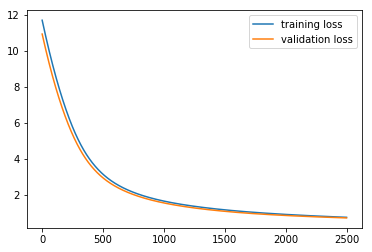

In [0]:
#################################### MODEL CONSTRUCTION ####################################
tf.reset_default_graph()
m, n = X_train.shape 
n_classes = len(np.unique(y_train))
learning_rate = 0.01
epsilon = 0.1 # to prevent underflow (division by zero when values become too small)

X = tf.placeholder(dtype=tf.float32, shape=(None, n))
y = tf.placeholder(dtype=tf.int32, shape=(None))
y_one_hot = tf.one_hot(y, n_classes)

W = tf.get_variable(name='weights', shape=(n, n_classes), initializer=random_normal)
logits = tf.matmul(X, W)
# Add in y_proba node so it can be called to make predictions later on
y_proba = tf.nn.softmax(logits)

log_loss = tf.losses.softmax_cross_entropy(onehot_labels=y_one_hot, logits=logits)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(log_loss)
init = tf.global_variables_initializer() 

#################################### MODEL EXECUTION ####################################
W_update = train_model(X_train, y_train, X_val, y_val)

Again, both the training and validation losses decrease per iteration. This is what we should expect as we are solving a simple convex optimization problem (a function is considered [convex](https://en.wikipedia.org/wiki/Convex_function),  if the line segment between any two points on the graph of the function lies above or on the graph ).

Now we wish to use the trained model to make predictions. Recall that all values in a TensorFlow graph are cleared once a session is closed, and thus we cannot simply run the `y_proba` node as we would be trying to run the model using uninitialized variables. This is why we return the trained weights node $W$ in the function above. 

Before proceeding, we will double check to make sure the updated weight parameters have the proper dimensions:

In [0]:
print('bias shape:', W_update[0].shape)
print('coefficients shape:', W_update[1:].shape)

bias shape: (10,)
coefficients shape: (64, 10)


To proceed with predictions, we will need to first feed the most updated weight values into the graph using `tf.assign`. We will also use a confusion matrix to briefly get a sense of how the model is performing. Again, we will wrap this code in a function to easily make predictions for future models.

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

def make_predictions(X_test, y_test, W_update):
    """Use trained model weights to make predictions"""
    with tf.Session() as sess:
        # Note that you could also simple enter 'W:W_update' into the feed_dict argument below 
        sess.run(tf.assign(W, W_update))
        # Feed in the test data and select the high probability as the prediction
        predictions = sess.run(tf.argmax(y_proba, axis=-1), feed_dict={X:X_test})
    # Show the confusion matrix
    print("Accuracy:", accuracy_score(y_test, predictions))
    print("Confusion Matrix:\n",confusion_matrix(y_test, predictions))

make_predictions(X_mnist, y_mnist, W_update)

Accuracy: 0.8497495826377296
Confusion Matrix:
 [[164   0   1   2   0   2   5   1   3   0]
 [  0 150   5   0   6   1   4   4   6   6]
 [  2   5 155  11   1   0   1   1   1   0]
 [  0   4   0 151   0   4   0   2  12  10]
 [  2   3   0   0 169   0   1   3   1   2]
 [  2   4   2   3   0 165   0   1   1   4]
 [  1   3   0   0   2   4 170   0   1   0]
 [  3   0   1   4   3   0   0 164   4   0]
 [  0  15   5   9   2   7   4   5 112  15]
 [  5  10   0  12   3   8   2   5   8 127]]


## Mini-Batch Gradient Descent

In **mini-batch gradient descent**, we train the model repeatedly on smaller subsets of the entire training data as opposed to the full training set itself. This can easily be implemented in our code by iterating through random subsets of the training data at each epoch.

For convenience, we implement the batch splitting algorithm as its own function

In [0]:
def fetch_batch(batch_size):
    indices = np.random.randint(m, size=batch_size)
    X_batch = X_train[indices]
    y_batch = y_train[indices]
    return X_batch, y_batch

Now we will update our prior `train_model` function to accommodate for mini-batch training. You should expect training to take a little longer as we now have extra iterations within each epoch depending on the batch size. This will contribute to algorithmic complexity greatly depending on how large the batch sizes are relative to how large the training set is.

Epoch 0 Train Loss = 10.662371 Validation Loss = 10.924294
Epoch 250 Train Loss = 1.4221576 Validation Loss = 1.5215482
Epoch 500 Train Loss = 0.7077136 Validation Loss = 0.86859876
Epoch 750 Train Loss = 0.48680604 Validation Loss = 0.671228
Epoch 1000 Train Loss = 0.3757375 Validation Loss = 0.56824166
Epoch 1250 Train Loss = 0.30439833 Validation Loss = 0.50459135
Epoch 1500 Train Loss = 0.25393933 Validation Loss = 0.4627774
Epoch 1750 Train Loss = 0.21544799 Validation Loss = 0.43260562
Epoch 2000 Train Loss = 0.1850494 Validation Loss = 0.4095011
Epoch 2250 Train Loss = 0.16135229 Validation Loss = 0.39164785


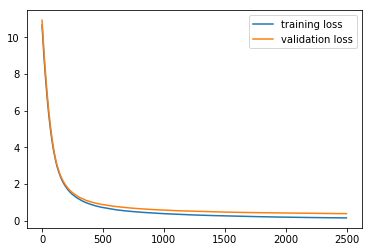

Accuracy: 0.8497495826377296
Confusion Matrix:
 [[164   0   1   2   0   2   5   1   3   0]
 [  0 150   5   0   6   1   4   4   6   6]
 [  2   5 155  11   1   0   1   1   1   0]
 [  0   4   0 151   0   4   0   2  12  10]
 [  2   3   0   0 169   0   1   3   1   2]
 [  2   4   2   3   0 165   0   1   1   4]
 [  1   3   0   0   2   4 170   0   1   0]
 [  3   0   1   4   3   0   0 164   4   0]
 [  0  15   5   9   2   7   4   5 112  15]
 [  5  10   0  12   3   8   2   5   8 127]]


In [0]:
import matplotlib.pyplot as plt

def train_model(X_train, y_train, X_val, y_val, epochs=2500, batch_size=300):
    # Open a session
    with tf.Session() as sess:
        sess.run(init)
        # Initialize loss values
        train_losses = []
        val_losses = []
        # Initialize batch values
        m = len(X_train)
        batches = int(m/batch_size)
        
        # Loop through the graph for n epochs
        for epoch in range(epochs):
            # Loop through the mini-batches
            for batch in range(batches):
                # Fetch a new batch
                X_batch, y_batch = fetch_batch(batch_size)
                # Run the training op
                sess.run([training_op], feed_dict={X:X_batch, y:y_batch})
            # Get trianing/validation loss
            train_loss = sess.run(log_loss, feed_dict={X:X_train, y:y_train})
            val_loss = sess.run(log_loss, feed_dict={X:X_val, y:y_val})
            # Save incremental loss values for visualization
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            if epoch % 250 == 0:
                print("Epoch", epoch, "Train Loss =", train_loss, "Validation Loss =", val_loss)
    # Plot loss values
    plt.plot(train_losses, label='training loss')
    plt.plot(val_losses, label='validation loss')
    plt.legend()
    plt.show()
    
    # Return updated weights
    return W_update

W_update = train_model(X_train, y_train, X_val, y_val)
make_predictions(X_mnist, y_mnist, W_update)

## Saving and Restoring models

Recall in the previous module we briefly discussed how to save and load graphs in TensorFlow. We will extend this functionality to save our current MNIST classification model. To accomplish this, we just need to create a new `tf.train.saver()` node after we have constructed our graph (i.e. after all variable nodes are created). Once we reach the execution phase, we can then call `save()` whenever we want to save the model. Doing so will require us to pass the saver with both the session and the path of where we wish to save the model components.

It is important to recognize that we ideally want to save our model at regular intervals throughout training. This ensures that our progress can be recovered in the case that something goes wrong during training. If the model is recoverable, we can proceed from when it was last saved as opposed to starting from the very beginning.

Now we will update our `train_model` function to include saving (in this case, we will save after every 250 epochs or iterations).

In [0]:
import matplotlib.pyplot as plt

def train_model(X_train, y_train, X_val, y_val, saver, epochs=2500, batch_size=300, save_path='./models/my_softmax_model.model'):
    # Open a session
    with tf.Session() as sess:
        sess.run(init)
        # Initialize loss values
        train_losses = []
        val_losses = []
        # Initialize batch values
        m = len(X_train)
        batches = int(m/batch_size)
        
        # Loop through the graph for n epochs
        for epoch in range(epochs):
            # Loop through the mini-batches
            for batch in range(batches):
                # Fetch a new batch
                X_batch, y_batch = fetch_batch(batch_size)
                # Run the training op
                sess.run([training_op], feed_dict={X:X_batch, y:y_batch})
            # Get training/validation loss
            train_loss = sess.run(log_loss, feed_dict={X:X_train, y:y_train})
            val_loss = sess.run(log_loss, feed_dict={X:X_val, y:y_val})
            # Save incremental loss values for visualization
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            # Save model and print results at 250 epochs
            if epoch % 250 == 0:
                saver.save(sess, save_path)
                print("Epoch", epoch, "Train Loss =", train_loss, "Validation Loss =", val_loss)
        # Save final model
        saver.save(sess, save_path)
    # Plot loss values
    plt.plot(train_losses, label='training loss')
    plt.plot(val_losses, label='validation loss')
    plt.legend()
    plt.show()
    
    # Return updated weights
    return W_update

With our training function modified, we now need to add a `tf.train.Saver()` object at the end of the code segment where we finish creating our model graph. Note that with our specified saved path, we save the model in ***/models/*** every 250 epochs.

Epoch 0 Train Loss = 12.681422 Validation Loss = 12.972495
Epoch 250 Train Loss = 1.6180229 Validation Loss = 1.8856086
Epoch 500 Train Loss = 0.83298486 Validation Loss = 1.076474
Epoch 750 Train Loss = 0.55128056 Validation Loss = 0.77666694
Epoch 1000 Train Loss = 0.39828655 Validation Loss = 0.6214355
Epoch 1250 Train Loss = 0.30339167 Validation Loss = 0.52774954
Epoch 1500 Train Loss = 0.24667947 Validation Loss = 0.46829095
Epoch 1750 Train Loss = 0.20711242 Validation Loss = 0.42745832
Epoch 2000 Train Loss = 0.17987935 Validation Loss = 0.39824453
Epoch 2250 Train Loss = 0.15975729 Validation Loss = 0.37596935


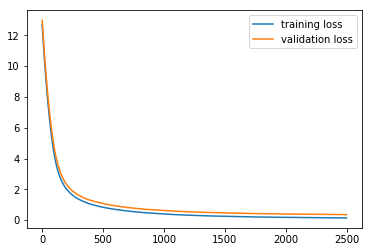

Accuracy: 0.8497495826377296
Confusion Matrix:
 [[164   0   1   2   0   2   5   1   3   0]
 [  0 150   5   0   6   1   4   4   6   6]
 [  2   5 155  11   1   0   1   1   1   0]
 [  0   4   0 151   0   4   0   2  12  10]
 [  2   3   0   0 169   0   1   3   1   2]
 [  2   4   2   3   0 165   0   1   1   4]
 [  1   3   0   0   2   4 170   0   1   0]
 [  3   0   1   4   3   0   0 164   4   0]
 [  0  15   5   9   2   7   4   5 112  15]
 [  5  10   0  12   3   8   2   5   8 127]]


In [0]:
#################################### MODEL CONSTRUCTION ####################################
tf.reset_default_graph()
m, n = X_train.shape 
n_classes = len(np.unique(y_train))
learning_rate = 0.01
epsilon = 0.1 # to prevent underflow

X = tf.placeholder(dtype=tf.float32, shape=(None, n), name='X')
y = tf.placeholder(dtype=tf.int32, shape=(None), name='y')
y_one_hot = tf.one_hot(y, n_classes)

W = tf.get_variable(name='weights', shape=(n, n_classes), initializer=random_normal)
logits = tf.matmul(X, W)
y_proba = tf.nn.softmax(logits, name='predict')

log_loss = tf.losses.softmax_cross_entropy(onehot_labels=y_one_hot, logits=logits)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(log_loss)
init = tf.global_variables_initializer() 

# Add the saver
saver = tf.train.Saver() 

#################################### MODEL EXECUTION ####################################
W_update = train_model(X_train, y_train, X_val, y_val, saver=saver)
make_predictions(X_mnist, y_mnist, W_update)

The saver gives us some flexibility in choosing what variables we wish to save. By default, the saver will save and restore all variables present in the graph under their respective names. To specify which variables to save and/or restore and what names to map them to, consider the following:

    saver = tf.train.Saver({"weights": theta})
    
The saver above will complete save and restore operations that only correspond to `theta` and map it to the name "weights". You are encouraged to use this feature at your own discretion depending on what you wish to preserve. For the time being, we will attempt to reload our trained model and make some predictions!

In [0]:
tf.reset_default_graph()

graph = tf.get_default_graph()
# this loads the graph structure
saver = tf.train.import_meta_graph('./models/my_softmax_model.model.meta')
# get the specific tensors with corresponding name
weights = graph.get_tensor_by_name('weights:0')
X = graph.get_tensor_by_name('X:0')
predict = graph.get_tensor_by_name('predict:0') 

with tf.Session() as sess:
    # load the state of the model
    saver.restore(sess, './models/my_softmax_model.model')
    print("Restored weights shape:",weights.eval().shape)
    predictions = np.argmax(sess.run(predict, feed_dict={X:X_val}), axis=1)
    
# Calculate the accuracy of our predictions
accuracy_score(y_val, predictions)

INFO:tensorflow:Restoring parameters from ./models/my_softmax_model.model
Restored weights shape: (65, 10)


0.9305555555555556

## Exercise

Leveraging the examples above, try building your own linear regression model using TensorFlow. You will be working with sklearn's **California housing price prediction** dataset, which we have loaded for you below. This exercise will involve 3 components:
1. Constructing your tf graph for the linear regression
2. Building the function to train the model
3. Building the function to make predictions

Save the functions as `train_model_linreg` and `make_predictions_linreg` so as to not overwrite our softmax model above.

In [0]:
from sklearn.datasets import california_housing
housing = california_housing.fetch_california_housing()
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [0]:
X_housing = housing["data"]
y_housing = housing["target"]
scaler = StandardScaler()
X_housing = scaler.fit_transform(X_housing)
X_housing = np.c_[np.ones((X_housing.shape[0],1)), X_housing]
X_housing_train, X_housing_val, y_housing_train, y_housing_val = train_test_split(X_housing, y_housing, test_size=0.2, shuffle=True)
y_housing_train = y_housing_train.reshape(-1,1)
y_housing_val= y_housing_val.reshape(-1,1)

print("X_train:", X_housing_train.shape)
print("X_val:", X_housing_val.shape)
print("y_train:", y_housing_train.shape)
print("y_val:", y_housing_val.shape)

X_train: (16512, 9)
X_val: (4128, 9)
y_train: (16512, 1)
y_val: (4128, 1)


### Response

In [0]:
# Construct linear regression Graph


In [0]:
# Build your train_model function 


In [0]:
# Build you make_predictions function


In [0]:
# Train your model and make predcitions


### Solution

In [0]:
import tensorflow as tf

# Build graph
tf.reset_default_graph()
m, n = X_housing_train.shape 
learning_rate = 0.01
epsilon = 0.1 # to prevent underflow

X = tf.placeholder(dtype=tf.float32, shape=(None, n))
y = tf.placeholder(dtype=tf.int32, shape=(None,1))

W = tf.get_variable(name='weights', shape=(n,1), initializer=random_normal)
y_pred = tf.matmul(X, W)

mse = tf.losses.mean_squared_error(labels=y, predictions=y_pred)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer() 

Epoch 0 Train Loss = 4.6974964 Validation Loss = 4.663599
Epoch 250 Train Loss = 0.84552336 Validation Loss = 0.9139853
Epoch 500 Train Loss = 0.7516865 Validation Loss = 0.8118078
Epoch 750 Train Loss = 0.7068341 Validation Loss = 0.7676641
Epoch 1000 Train Loss = 0.68507195 Validation Loss = 0.74834657
Epoch 1250 Train Loss = 0.67434704 Validation Loss = 0.73997986
Epoch 1500 Train Loss = 0.6689597 Validation Loss = 0.73637414
Epoch 1750 Train Loss = 0.6661916 Validation Loss = 0.734794
Epoch 2000 Train Loss = 0.66473234 Validation Loss = 0.73405075
Epoch 2250 Train Loss = 0.6639416 Validation Loss = 0.7336429


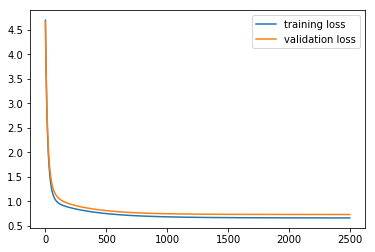

In [0]:
# Build train_model function
import matplotlib.pyplot as plt
def train_model_linreg(X_train, y_train, X_val, y_val, epochs=2500):
    with tf.Session() as sess:
        sess.run(init)
        train_losses = []
        val_losses = []
        for epoch in range(epochs):
            _, train_loss, W_update = sess.run([training_op, mse, W], feed_dict={X:X_train, y:y_train})
            val_loss = sess.run(mse, feed_dict={X:X_val, y:y_val})
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            if epoch % 250 == 0:
                print("Epoch", epoch, "Train Loss =", train_loss, "Validation Loss =", val_loss)
    plt.plot(train_losses, label='training loss')
    plt.plot(val_losses, label='validation loss')
    plt.legend()
    plt.show()
    return W_update

W_trained = train_model_linreg(X_housing_train, y_housing_train, X_housing_val, y_housing_val)

In [0]:
from sklearn.metrics import mean_squared_error

def make_predictions_linreg(X_test, y_test, W_trained):
    """Use trained model weights to make predictions"""
    with tf.Session() as sess:
        sess.run(tf.assign(W, W_trained))
        predictions = sess.run(y_pred, feed_dict={X:X_test})
    print("Mean squared error:", mean_squared_error(y_test, predictions))

make_predictions_linreg(X_housing, y_housing, W_trained)

Mean squared error: 0.7846815811395077


# Visualizing Models with Tensorboard

## Overview of Tensorboard and Logging

As of now, we have successfully implemented a computation graph and run several training epochs for a softmax classifier using mini-batch gradient descent. Furthermore, we are saving our model at regular training intervals using the `tf.trian.saver` module. If you've gotten this far, you now know enough about TensorFlow to build your own machine learning models! You are encouraged to try running these simple TensorFlow models on new datasets, and leverage the documentation to build more diverse and sophisticated models (which we will be doing in the next module). For now, let's move on to the next topic in this module; **model visualization using Tensorboard**.

TensorBoard allows the user to display interactive visualizations of a model's graph structure and its training outputs, all through a simple web browser interface. The user can easily interact with and drill down into their graph structure through intuitive visualizations, which can be incredibly helpful when trying to identify bugs or issues with your model architecture.

To get started with TensorBoard, we need to make note of the following:
- We need to tweak our `train_model` function to record training statistics (MSE, loss, train_error, val_error, etc.) at regular intervals. We will record these details in a log file using the `tf.summary.FileWriter` function.
- Every time we run the program, we need to revert to a different log directory. Otherwise, TensorFlow will automatically merge the statistics of different runs and will ultimately corrupt the visualizations we see in TensorBoard.

In order to avoid the cross-contamination of log files, we can easily append timestamps to the filenames to ensure that the statistics of each model run are saved in a unique log file. The following code segment achieves this:
    
        from datetime import datetime
        now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
        root_logdir = "tf_logs"
        logdir = "{}/run-{}/".format(root_logdir, now)

We would also need to add the following at the end of our model construction phase code:
    
        logloss_summary = tf.summary.scalar('log_loss', log_loss)
        file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())
    
The first line adds a new node in the graph that is responsible for calculating the log_loss. This is then converted into a binary log string that called a **summary**, which is format readable for TensorBoard. The second line creates the corresponding FileWriter that is used to write the summaries to the log files in the directory.
    
**NOTE:** For the FileWriter, if the specified directory (i.e. `logdir`) does not actually exist, **it will automatically create the directory and the preceding parent directories if needed.** The directories specified in the FileWriter object are *relative* to where the current Python file is. Furthermore, the file to which the summaries are written to is also known as an **events file**.

After the above modifications are made, we also need to revise the execution phase to evaluate the `logloss_summary` node during training. Again, this will result in a summary that can then in turn be written to the events file. Once all logs are recorded, it is then acceptable to close the FieWriter (i.e. at the end of the program).

Let's update our code!

In [0]:
from datetime import datetime

# function to create our log directories
def get_logdir():
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    return  "{}/run-{}/".format(root_logdir, now)
# run this cell to see how the format of our log folders read as
get_logdir()

'tf_logs/run-20190210041621/'

In [0]:
#################################### MODEL CONSTRUCTION ####################################
tf.reset_default_graph()
m, n = X_train.shape 
n_classes = len(np.unique(y_train))
learning_rate = 0.01
epsilon = 0.1 # to prevent underflow

X = tf.placeholder(dtype=tf.float32, shape=(None, n), name='X')
y = tf.placeholder(dtype=tf.int32, shape=(None), name='y')
y_one_hot = tf.one_hot(y, n_classes)

W = tf.get_variable(name='weights', shape=[n, n_classes], initializer=random_normal)
logits = tf.matmul(X, W)
y_proba = tf.nn.softmax(logits, name='predict')

log_loss = tf.losses.softmax_cross_entropy(onehot_labels=y_one_hot, logits=logits)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(log_loss)
init = tf.global_variables_initializer() 
saver = tf.train.Saver() 

# Add lines to write model to file
logdir = get_logdir()
loss_summary = tf.summary.scalar('log_loss', log_loss) 
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

Upon instantiation of `tf.summary.FileWriter`, we can see that TensorFlow immediately creates a file to the directory specified (i.e. in this case the directory is the out of the `get_logdir()` function). This is because on creation, the FileWriter object will create the **"file stream"** and continually write to it as the `save()` function is called. Thus, **it is important that you reset the graph on every new session to force a new file (i.e. log directory file) to be created. If not, multiple session runs will result in duplicate event files which is not what we want.**

With this in mind, we will now run the model.

Epoch 0 Train Loss = 12.2022295 Validation Loss = 12.394914
Epoch 250 Train Loss = 1.7059025 Validation Loss = 1.867842
Epoch 500 Train Loss = 0.78918654 Validation Loss = 0.98245394
Epoch 750 Train Loss = 0.49671638 Validation Loss = 0.7289132
Epoch 1000 Train Loss = 0.36092353 Validation Loss = 0.6212871
Epoch 1250 Train Loss = 0.28416026 Validation Loss = 0.5610999
Epoch 1500 Train Loss = 0.23513268 Validation Loss = 0.5230874
Epoch 1750 Train Loss = 0.20198353 Validation Loss = 0.4957424
Epoch 2000 Train Loss = 0.17804828 Validation Loss = 0.47562137
Epoch 2250 Train Loss = 0.15993229 Validation Loss = 0.4586993


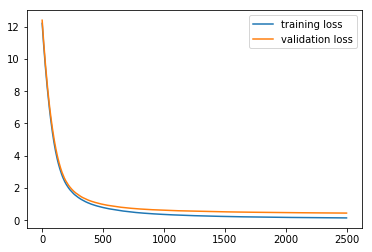

Accuracy: 0.8497495826377296
Confusion Matrix:
 [[164   0   1   2   0   2   5   1   3   0]
 [  0 150   5   0   6   1   4   4   6   6]
 [  2   5 155  11   1   0   1   1   1   0]
 [  0   4   0 151   0   4   0   2  12  10]
 [  2   3   0   0 169   0   1   3   1   2]
 [  2   4   2   3   0 165   0   1   1   4]
 [  1   3   0   0   2   4 170   0   1   0]
 [  3   0   1   4   3   0   0 164   4   0]
 [  0  15   5   9   2   7   4   5 112  15]
 [  5  10   0  12   3   8   2   5   8 127]]


In [0]:
# MAKE SURE YOU RUN MODEL CONSTRUCTION CELL BEFORE RUNNING THIS CELL
def train_model(X_train, y_train, X_val, y_val, epochs=2500, batch_size=300, save_path='./models/my_softmax_model.model'):
    # Open a session
    with tf.Session() as sess:
        sess.run(init)
        # Initialize loss values
        train_losses = []
        val_losses = []
        # Initialize batch vALUES
        m = len(X_train)
        batches = int(m/batch_size)
        
        # Loop through the graph for n epochs
        for epoch in range(epochs):
            # Loop through the mini-batches
            for batch in range(batches):
                # Fetch a new batch
                X_batch, y_batch = fetch_batch(batch_size)
                # Run the training op
                sess.run([training_op], feed_dict={X:X_batch, y:y_batch})
                # Save outputs at every batch
                summary_str = loss_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = (epoch+1) * (batch + 1)
                file_writer.add_summary(summary_str, step)
            # Get trianing/validation loss
            train_loss = sess.run(log_loss, feed_dict={X:X_train, y:y_train})
            val_loss = sess.run(log_loss, feed_dict={X:X_val, y:y_val})
            # Save incremental loss values for visualization
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            # Save model and print results at 250 epochs
            if epoch % 250 == 0:
                saver.save(sess, save_path)
                print("Epoch", epoch, "Train Loss =", train_loss, "Validation Loss =", val_loss)
        # Save final model
        saver.save(sess, save_path)
    # Plot loss values
    plt.plot(train_losses, label='training loss')
    plt.plot(val_losses, label='validation loss')
    plt.legend()
    plt.show()
    
    # Return updated weights
    return W_update

W_update = train_model(X_train, y_train, X_val, y_val)
make_predictions(X_mnist, y_mnist, W_update)

## Accessing Tensorboard

To begin, enter this code into the command line (make sure you are in the correct directory first):
    
    dir tf_logs
    
The code should give you a list of log file names in tf_logs, and each file should represent a unique model run (assuming you re-ran the construction phase of the code before running the training phase each time)! Now, to open Tensorboard all you have to do is enter the following code in your command line, entering 'tf_logs' directory as the '--logdir' argument:
    
    tensorboard --logdir tf_logs/
    
You should see something like this returned:
    
    TensorBoard 1.12.2 at http://CA47496-MCINI06:6006 (Press CTRL+C to quit)

To open TensorBoard, all you have to do is copy and pase the linke provided into your browser.

The **graphs** tab should look as follows:

<img src='Module 9 images/c4_m9_p2_tb1.png' style="float:left;width:1000px;height:600;">



The **scalers** tab should look as follows:

<img src='Module 9 images/c4_m9_p2_tb2.png' style="float:left;width:1000px;height:600;">


## Improving you TensorBoard Output

Lastly, we can improve upon our TensorBoard output by using name scopes. Using name scopes not only makes your code more readable, it also make the corresponding TensorBoard visualizations easier to follow. Tensorboard will essentially group all of the nodes from a single name scope into a bucket, which can make navigating a models architecture much simpler. See the code below for an example of what this could look like. 

Epoch 0 Train Loss = 12.4131365 Validation Loss = 12.572943
Epoch 250 Train Loss = 1.5963033 Validation Loss = 1.7275982
Epoch 500 Train Loss = 0.8345398 Validation Loss = 0.9931069
Epoch 750 Train Loss = 0.55881095 Validation Loss = 0.7114693
Epoch 1000 Train Loss = 0.41240004 Validation Loss = 0.5624761
Epoch 1250 Train Loss = 0.32239437 Validation Loss = 0.46463266
Epoch 1500 Train Loss = 0.26140845 Validation Loss = 0.39910907
Epoch 1750 Train Loss = 0.2166153 Validation Loss = 0.35269657
Epoch 2000 Train Loss = 0.18503301 Validation Loss = 0.32287103
Epoch 2250 Train Loss = 0.16419493 Validation Loss = 0.30122072


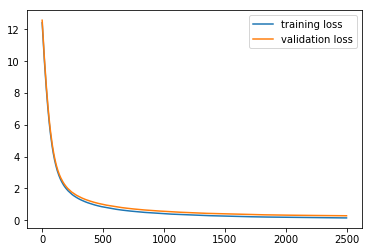

Accuracy: 0.8497495826377296
Confusion Matrix:
 [[164   0   1   2   0   2   5   1   3   0]
 [  0 150   5   0   6   1   4   4   6   6]
 [  2   5 155  11   1   0   1   1   1   0]
 [  0   4   0 151   0   4   0   2  12  10]
 [  2   3   0   0 169   0   1   3   1   2]
 [  2   4   2   3   0 165   0   1   1   4]
 [  1   3   0   0   2   4 170   0   1   0]
 [  3   0   1   4   3   0   0 164   4   0]
 [  0  15   5   9   2   7   4   5 112  15]
 [  5  10   0  12   3   8   2   5   8 127]]


In [0]:
#################################### MODEL CONSTRUCTION ####################################
tf.reset_default_graph()
m, n = X_train.shape 
n_classes = len(np.unique(y_train))
learning_rate = 0.01
epsilon = 0.1 # to prevent underflow

with tf.variable_scope('INPUTS'):
    X = tf.placeholder(dtype=tf.float32, shape=(None, n), name='X')
    y = tf.placeholder(dtype=tf.int32, shape=(None), name='y')
    y_one_hot = tf.one_hot(y, n_classes)

with tf.variable_scope('LINEAR_FORWARD'):
    W = tf.get_variable(name='weights', shape=[n, n_classes], initializer=random_normal)
    logits = tf.matmul(X, W, name='logits')
    y_proba = tf.nn.softmax(logits, name='predictions') # Add in y_pred node so it can be called to make predictions

with tf.variable_scope('LOSS_CALC'):
    log_loss = tf.losses.softmax_cross_entropy(onehot_labels=y_one_hot, logits=logits)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(log_loss)

logdir = get_logdir()
with tf.variable_scope('SAVE'):
    loss_summary = tf.summary.scalar('log_loss', log_loss) 
    file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())
    saver = tf.train.Saver() 

init = tf.global_variables_initializer() 

#################################### MODEL EXECUTION ####################################
def train_model(X_train, y_train, X_val, y_val, epochs=2500, batch_size=300, save_path='./models/my_softmax_model.model'):
    # Open a session
    with tf.Session() as sess:
        sess.run(init)
        # Initialize loss values
        train_losses = []
        val_losses = []
        # Initialize batch vALUES
        m = len(X_train)
        batches = int(m/batch_size)
        
        # Loop through the graph for n epochs
        for epoch in range(epochs):
            # Loop through the mini-batches
            for batch in range(batches):
                # Fetch a new batch
                X_batch, y_batch = fetch_batch(batch_size)
                # Run the training op
                sess.run([training_op], feed_dict={X:X_batch, y:y_batch})
                # Save outputs at every batch
                summary_str = loss_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = (epoch+1) * (batch + 1)
                file_writer.add_summary(summary_str, step)
            # Get trianing/validation loss
            train_loss = sess.run(log_loss, feed_dict={X:X_train, y:y_train})
            val_loss = sess.run(log_loss, feed_dict={X:X_val, y:y_val})
            # Save incremental loss values for visualization
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            # Save model and print results at 250 epochs
            if epoch % 250 == 0:
                saver.save(sess, save_path)
                print("Epoch", epoch, "Train Loss =", train_loss, "Validation Loss =", val_loss)
        # Save final model
        saver.save(sess, save_path)
    # Plot loss values
    plt.plot(train_losses, label='training loss')
    plt.plot(val_losses, label='validation loss')
    plt.legend()
    plt.show()
    
    # Return updated weights
    return W_update

W_update = train_model(X_train, y_train, X_val, y_val)
make_predictions(X_mnist, y_mnist, W_update)

The **graphs** tab should look like after we added variable scopes to our code:

<img src='Module 9 images/c4_m9_p2_tb3.png' style="float:left;width:1000px;height:600;">


**End of Module.** 

You have reached the end of this module.
If you have any questions, please reach out to your peers using the discussion boards. If you and your peers are unable to come to a suitable conclusion, do not hesitate to reach out to your instructor on the designated discussion board.
When you are comfortable with the content, and have practiced to your satisfaction, you may proceed to any related assignments, and to the next module.

# References

Géron, A. (2017). Chapter 9: Up and Running with TensorFlow and Chapter 10: Introduction to Artificial Neural Networks in Hands-On Machine Learning with Scikit-Learn and TensorFlow O’Reilly Media http://shop.oreilly.com/product/0636920052289.do![image.png](attachment:image.png)

TensorFlow documentation and tutorials: https://www.tensorflow.org/tutorials



# Supplemental Material - TensorFlow2.0

As the materials for this course were being created, the team at TensorFlow released **TensorFlow 2.0 (TF2)**, the second version of the package. 

Your knowledge of TensorFlow 1.0 (TF1) will still remain very important; nearly all TensorFlow models are still running on stable TF1 code, and much of the TensorFlow codebase remains that same. That said, there are some exciting updates in TF2 that can vastly improve the model building process and will likely become industry standard relatively quickly, so it’s important that you begin to understand these changes.

Some of the major changes include:

* **API cleanup**: Many APIs like tf.gans, tf.app, tf.contrib, tf.flags are either gone or moved to separate repositories.
* **Eager Execution**: As you might recall, to build a Neural Net in TF1, we needed to define this abstract data structure called a Graph, and then to actually run the graph we needed to use an encapsulation called a Session. With eager execution, this changes. Now, TensorFlow code can be run like normal Python code. Meaning that operations are created and evaluated at once.
* **Functions, not sessions**: A session.run() call is almost like a function call: You specify the inputs and the function to be called, and you get back a set of outputs. In TensorFlow 2.0, you can decorate a Python function using tf.function() to mark it for JIT compilation so that TensorFlow runs it as a single graph. That’s right, no more sessions!
* **No more globals**: TensorFlow 1.0 relied heavily on implicitly global namespaces. When you called tf.Variable(), it would be put into the default graph, and it would remain there, even if you lost track of the Python variable pointing to it. You could then recover that tf.Variable, but only if you knew the name that it had been created with (which was often a huge pain). TensorFlow 2.0 eliminates all of these mechanisms in favor of the default mechanism: Keep track of your variables! If you lose track of a tf.Variable, it gets garbage collected (essentially erased from memory). The requirement to track variables creates some extra work for the user, but with Keras objects, the burden is minimized.
* **Tight integration with Keras**: Keras is now the default and recommended high-level API for TensorFlow. The easiest way to train a model in TF 2.0 is by using the .fit() method on a Keras Sequential or Functional model (we cover Keras in more detail in the next module). This method is ideal for rapid prototyping for any type of model, and saves the user from having to tediously construct complicated model construction and execution pipelines.


There are many more exciting changes in TF2, and you are encouraged to take a deep dive into all of them. To get started, take a look at the following sources:
* TensorFlow 2.0 documentation: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf
* The ‘Effective TensorFlow 2.0 Guide’, produced by the TensorFlow team: https://github.com/tensorflow/docs/blob/master/site/en/r2/guide/effective_tf2.md
* Thalles Silva’s very thorough overview of the major changes in this HackerNoon article: https://hackernoon.com/everything-you-need-to-know-about-tensorflow-2-0-b0856960c074
